In [1]:
import pathlib
import sys

import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    optimized_model_create,
    parameter_set,
    results_output,
    test_optimized_model,
    un_nest,
)

sys.path.append("../../..")

In [2]:
# Parameters
SHUFFLE_DATA = False
CELL_TYPE = "PBMC"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
TREATMENT_NAME = "Thapsigargin_1.000_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_Thapsigargin_1"

In [3]:
ml_configs_file = pathlib.path("../../MLP_utils/binary_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite mlp_params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.MODEL_NAME = MODEL_NAME

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = pathlib.path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()

In [5]:
def test_loop(df, output_name, title):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    mlp_params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", mlp_params.IN_FEATURES)
    if mlp_params.MODEL_TYPE == "Regression":
        mlp_params.OUT_FEATURES = 1
    else:
        mlp_params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", mlp_params.OUT_FEATURES)

    if mlp_params.OUT_FEATURES > 2:
        mlp_params.MODEL_TYPE = "Multi_Class"
    elif mlp_params.OUT_FEATURES == 2:
        mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
        mlp_params.MODEL_TYPE = "Binary_Classification"
    elif mlp_params.OUT_FEATURES == 1:
        mlp_params.MODEL_TYPE = "Regression"
    else:
        pass
    print(mlp_params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(mlp_params, mlp_params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if mlp_params.MODEL_TYPE == "Multi_Class" or mlp_params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, mlp_params, model_name=mlp_params.MODEL_NAME
        )
    elif mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, mlp_params, model_name=mlp_params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputting list values of tested model
    if mlp_params.MODEL_TYPE == "Multi_Class" or mlp_params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            mlp_params,
            test_name=f"{output_name}_all_testing",
            model_name=mlp_params.MODEL_NAME,
        )
    elif mlp_params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            mlp_params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=mlp_params.MODEL_NAME,
            title=title,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [6]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025', 'DMSO_0.100_DMSO_0.025',
       'media_ctr_0_Media_ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'DMSO_0.100_Z-VAD-FMK_100.0',
       'DMSO_0.100_Z-VAD-FMK_30.0', 'LPS_10.000_Disulfiram_0.1',
       'LPS_10.000_Disulfiram_1.0', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.5_DMSO_0.025', 'Disulfiram_2.500_DMSO_0.025',
       'Topotecan_5.000_DMSO_0.025', 'Topotecan_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_2.5', 'LPS_10.000_Z-VAD-FMK_100.0',
       'H2O2_100.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_100.000_DMSO_0.025', 'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'H2O2_100.000_Disulfiram_1.0', 'H2O2_100.000_

In [7]:
paired_treatment_list = [
    ["DMSO_0.100_DMSO_0.025", "LPS_100.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_0.100_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_10.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_100.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Flagellin_0.100_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Flagellin_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Flagellin_1.000_Disulfiram_1.0"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_100.000_1.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_100.000_3.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_100.000_10.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_1.000_1.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_1.000_3.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_1.000_10.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "H2O2_100.000_Z-VAD-FMK_100.0"],
    ["DMSO_0.100_DMSO_0.025", "H2O2_100.000_DMSO_0.025"],
    ["LPS_100.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_100.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_0.010_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_0.010_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
]

DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.67      0.92      0.78    215130
           1       0.79      0.40      0.53    159435

    accuracy                           0.70    374565
   macro avg       0.73      0.66      0.65    374565
weighted avg       0.72      0.70      0.67    374565



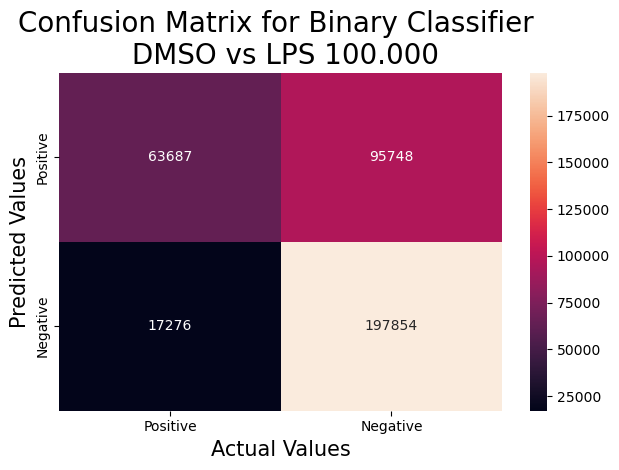

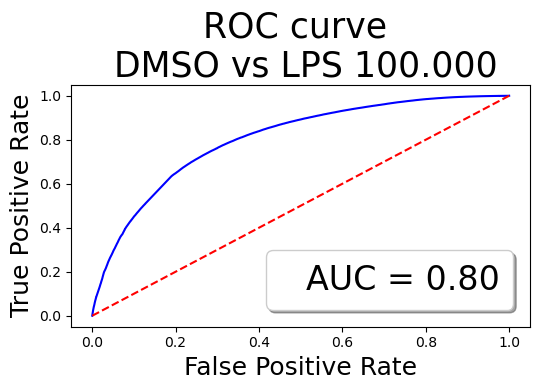

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.83      0.92      0.87    215130
           1       0.86      0.72      0.78    148456

    accuracy                           0.84    363586
   macro avg       0.84      0.82      0.83    363586
weighted avg       0.84      0.84      0.83    363586



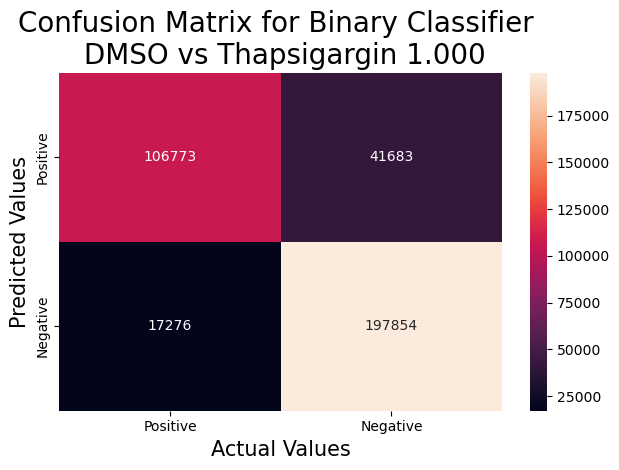

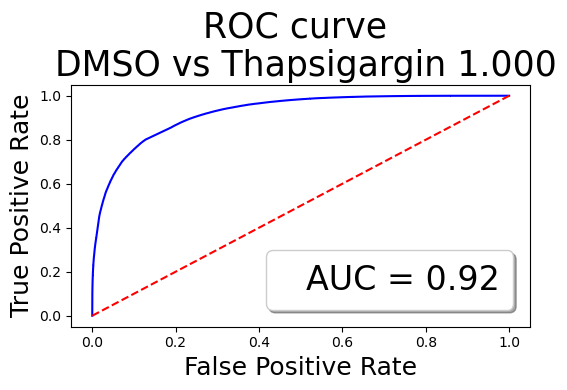

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.83      0.92      0.87    215130
           1       0.88      0.76      0.82    166984

    accuracy                           0.85    382114
   macro avg       0.86      0.84      0.84    382114
weighted avg       0.85      0.85      0.85    382114



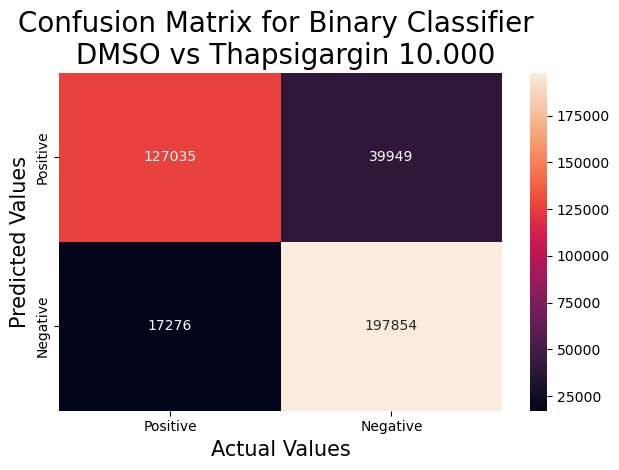

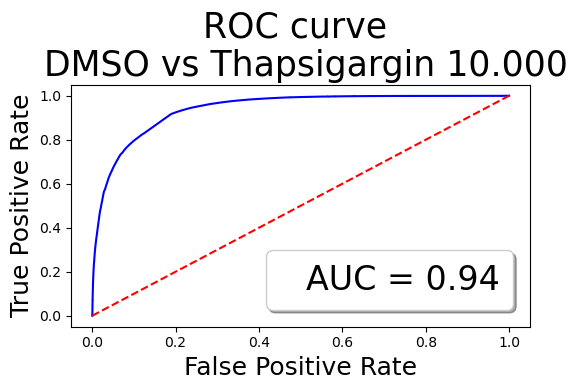

LPS_0.100_DMSO_0.025 DMSO_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.73      0.92      0.81    215130
           1       0.79      0.47      0.59    138597

    accuracy                           0.74    353727
   macro avg       0.76      0.70      0.70    353727
weighted avg       0.75      0.74      0.73    353727



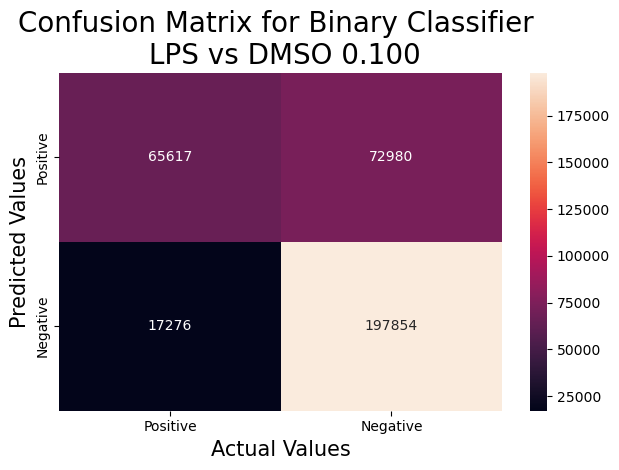

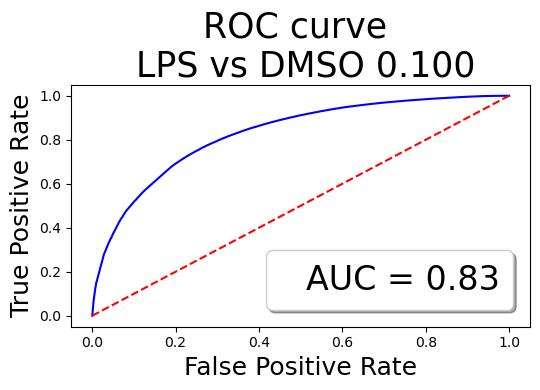

DMSO_0.100_DMSO_0.025 LPS_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.77      0.92      0.84    215130
           1       0.82      0.58      0.68    139433

    accuracy                           0.78    354563
   macro avg       0.80      0.75      0.76    354563
weighted avg       0.79      0.78      0.77    354563



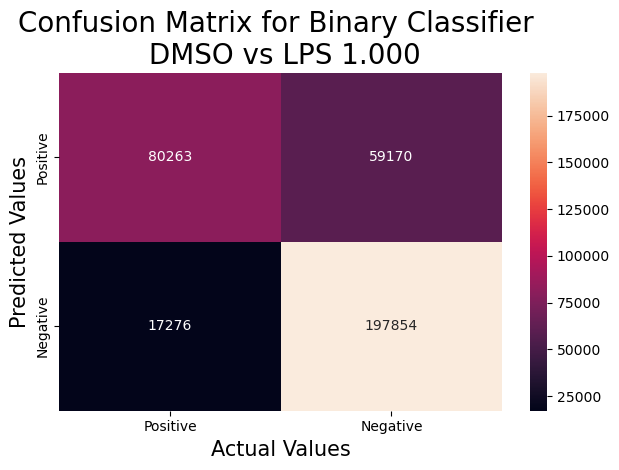

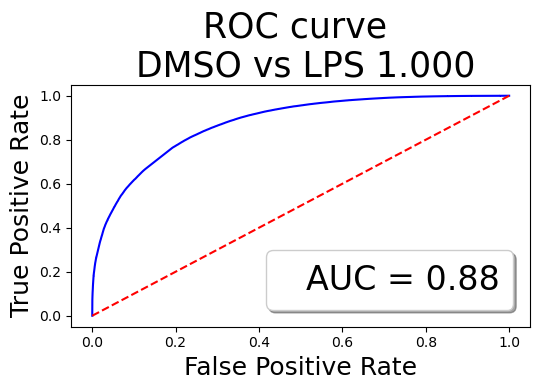

DMSO_0.100_DMSO_0.025 LPS_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.77      0.92      0.84    215130
           1       0.85      0.62      0.71    156490

    accuracy                           0.79    371620
   macro avg       0.81      0.77      0.78    371620
weighted avg       0.80      0.79      0.78    371620



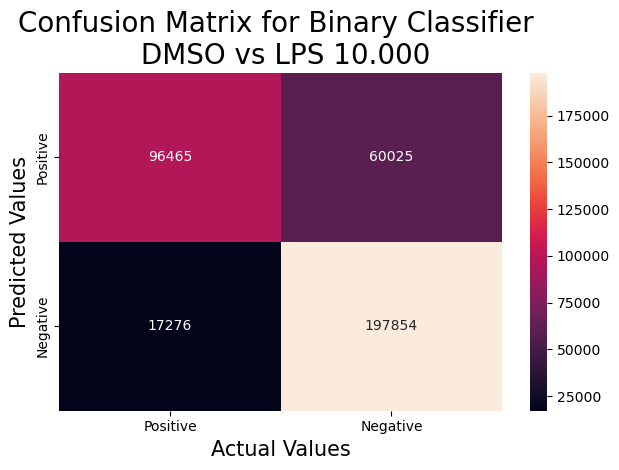

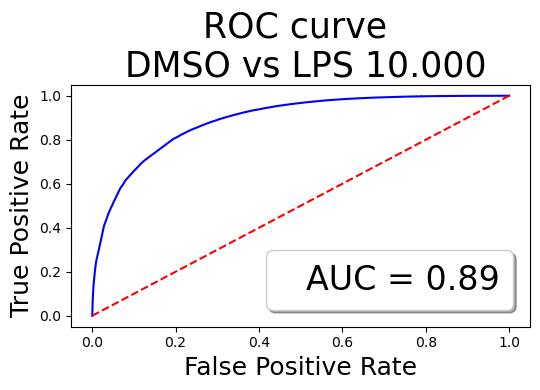

DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.67      0.92      0.78    215130
           1       0.79      0.40      0.53    159435

    accuracy                           0.70    374565
   macro avg       0.73      0.66      0.65    374565
weighted avg       0.72      0.70      0.67    374565



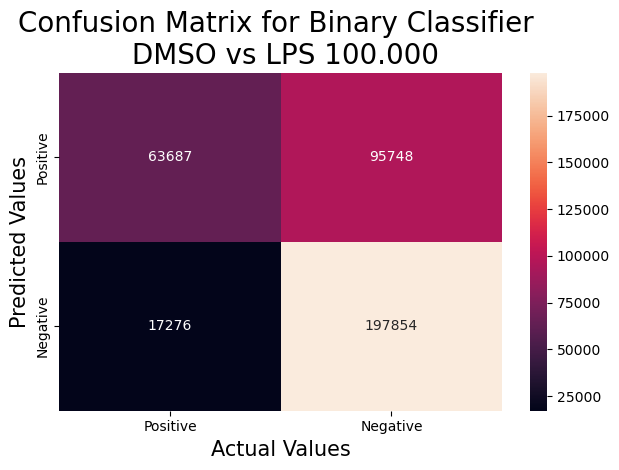

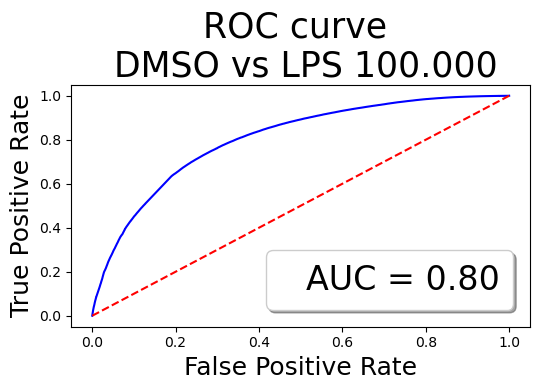

DMSO_0.100_DMSO_0.025 Flagellin_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.78      0.92      0.84    215130
           1       0.70      0.42      0.52     95915

    accuracy                           0.76    311045
   macro avg       0.74      0.67      0.68    311045
weighted avg       0.75      0.76      0.74    311045



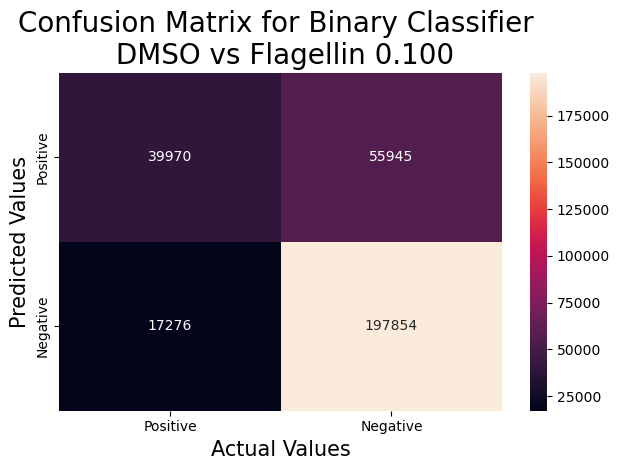

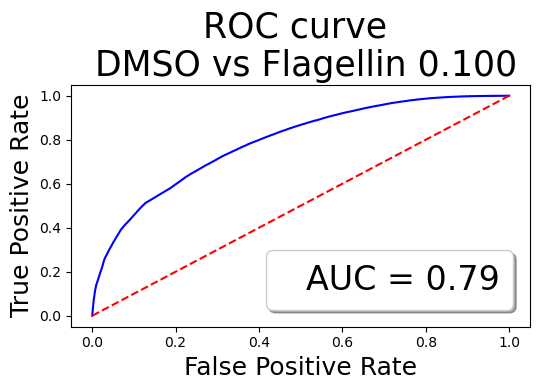

DMSO_0.100_DMSO_0.025 Flagellin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.78      0.92      0.85    215130
           1       0.74      0.47      0.58    104547

    accuracy                           0.77    319677
   macro avg       0.76      0.70      0.71    319677
weighted avg       0.77      0.77      0.76    319677



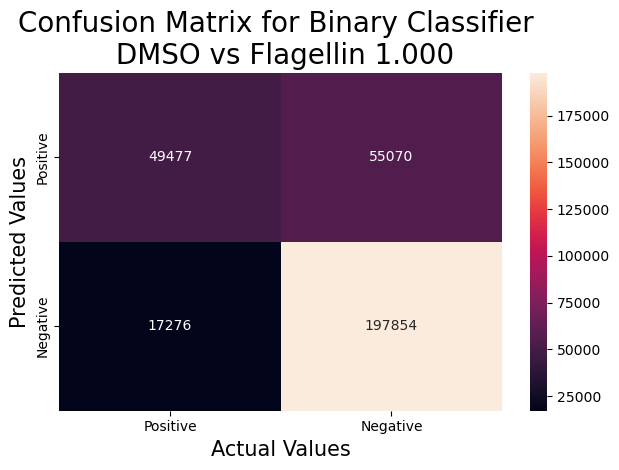

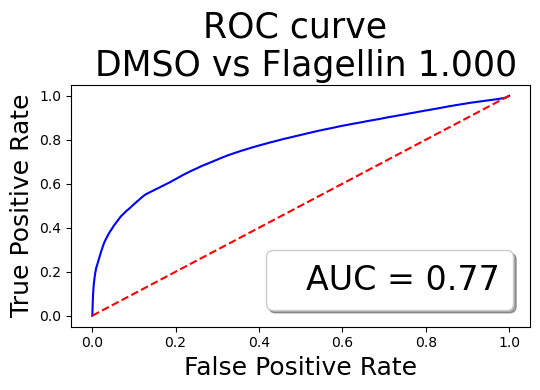

DMSO_0.100_DMSO_0.025 Flagellin_1.000_Disulfiram_1.0


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.85      0.92      0.88    215130
           1       0.86      0.76      0.81    145552

    accuracy                           0.85    360682
   macro avg       0.86      0.84      0.85    360682
weighted avg       0.86      0.85      0.85    360682



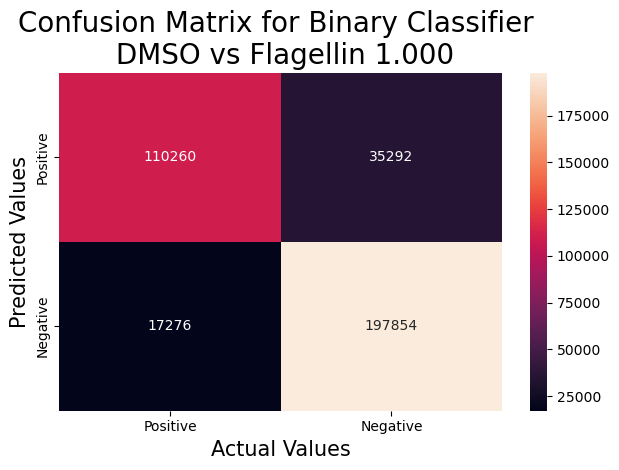

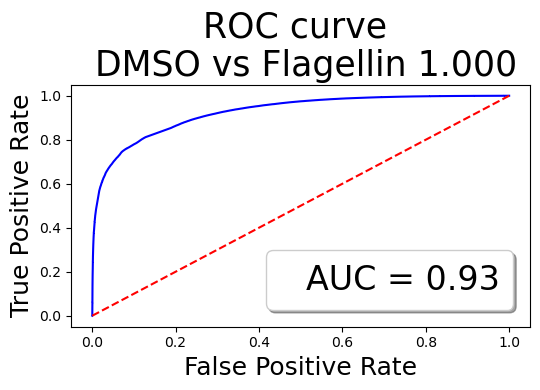

LPS_Nigericin_100.000_1.0_DMSO_0.025 DMSO_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.77      0.92      0.84    215130
           1       0.87      0.66      0.75    170659

    accuracy                           0.81    385789
   macro avg       0.82      0.79      0.80    385789
weighted avg       0.82      0.81      0.80    385789



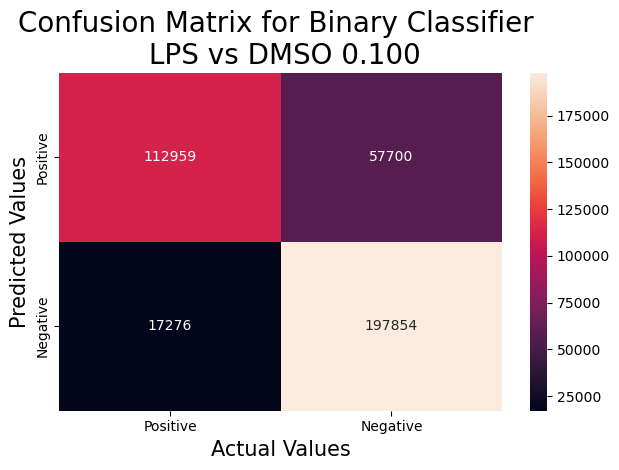

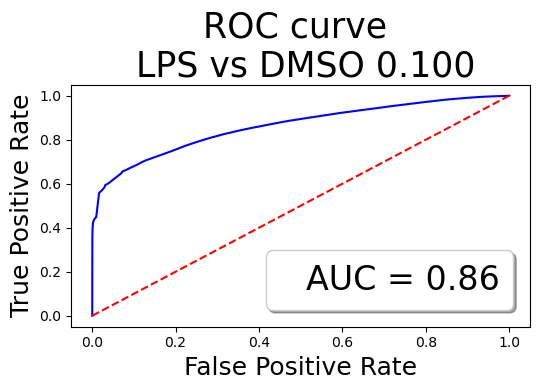

LPS_Nigericin_100.000_3.0_DMSO_0.025 DMSO_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.81      0.92      0.86    215130
           1       0.89      0.75      0.81    184854

    accuracy                           0.84    399984
   macro avg       0.85      0.83      0.84    399984
weighted avg       0.85      0.84      0.84    399984



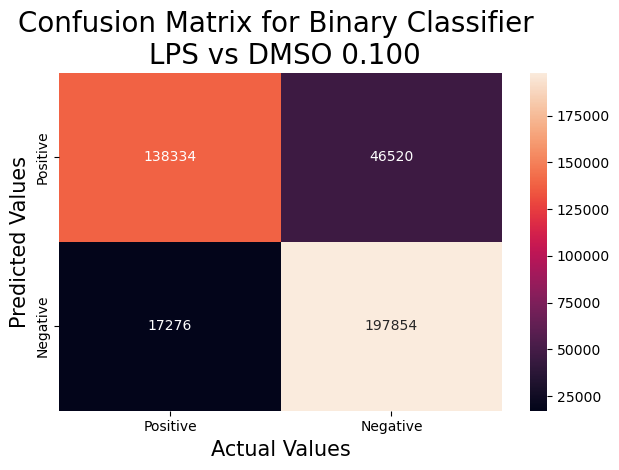

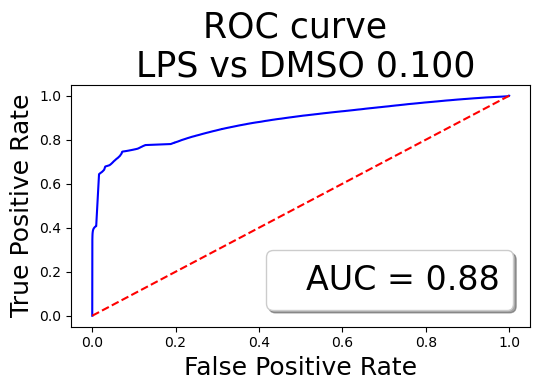

DMSO_0.100_DMSO_0.025 LPS_Nigericin_100.000_10.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.77      0.92      0.84    215130
           1       0.87      0.67      0.76    176090

    accuracy                           0.81    391220
   macro avg       0.82      0.79      0.80    391220
weighted avg       0.82      0.81      0.80    391220



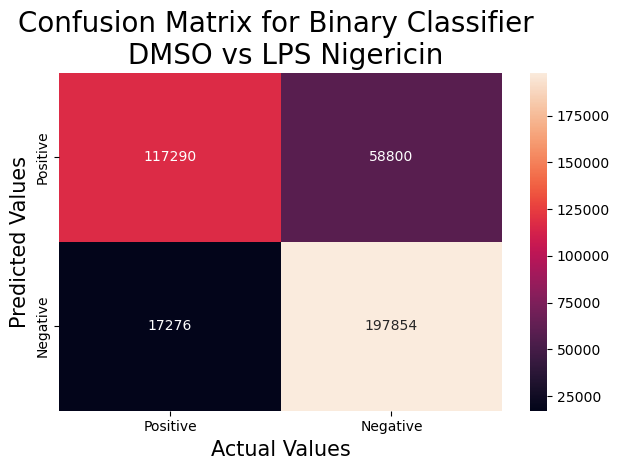

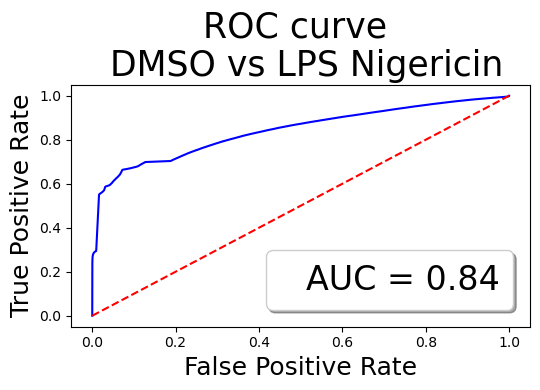

DMSO_0.100_DMSO_0.025 LPS_Nigericin_1.000_1.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.65      0.92      0.76    215130
           1       0.78      0.37      0.50    166013

    accuracy                           0.68    381143
   macro avg       0.72      0.64      0.63    381143
weighted avg       0.71      0.68      0.65    381143



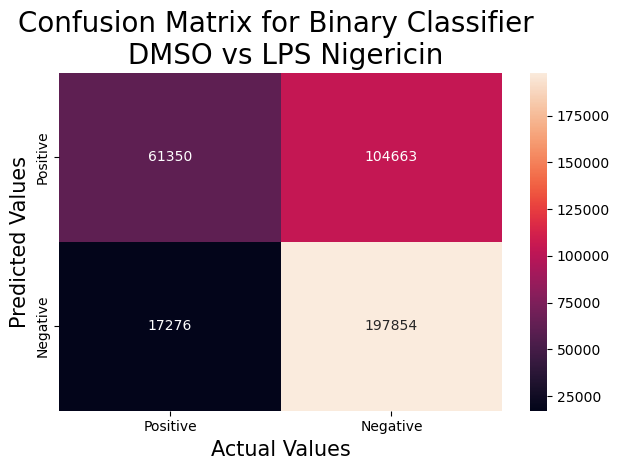

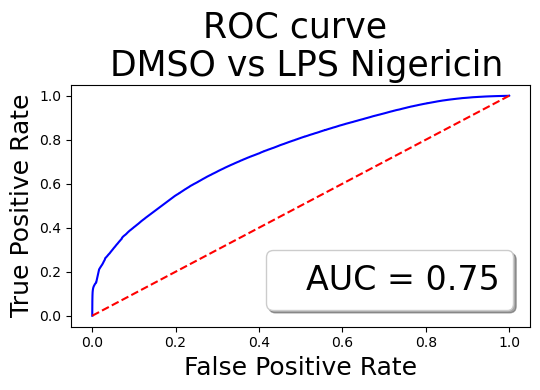

DMSO_0.100_DMSO_0.025 LPS_Nigericin_1.000_3.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.65      0.92      0.76    215130
           1       0.79      0.38      0.51    174261

    accuracy                           0.68    389391
   macro avg       0.72      0.65      0.64    389391
weighted avg       0.71      0.68      0.65    389391



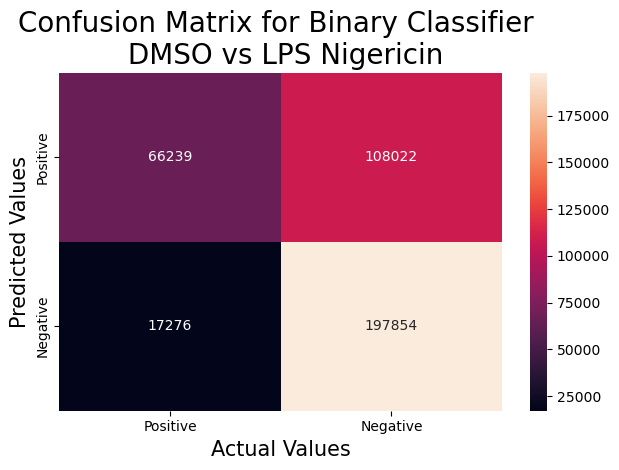

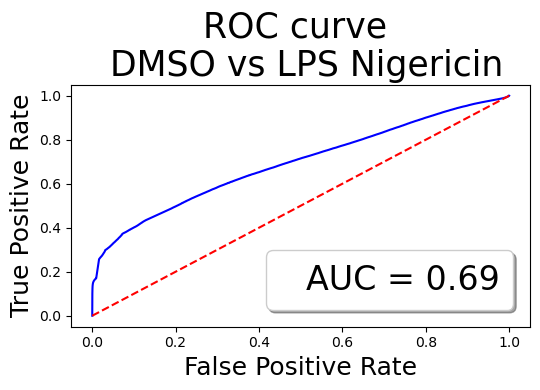

DMSO_0.100_DMSO_0.025 LPS_Nigericin_1.000_10.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.61      0.92      0.74    215130
           1       0.77      0.31      0.44    181166

    accuracy                           0.64    396296
   macro avg       0.69      0.62      0.59    396296
weighted avg       0.68      0.64      0.60    396296



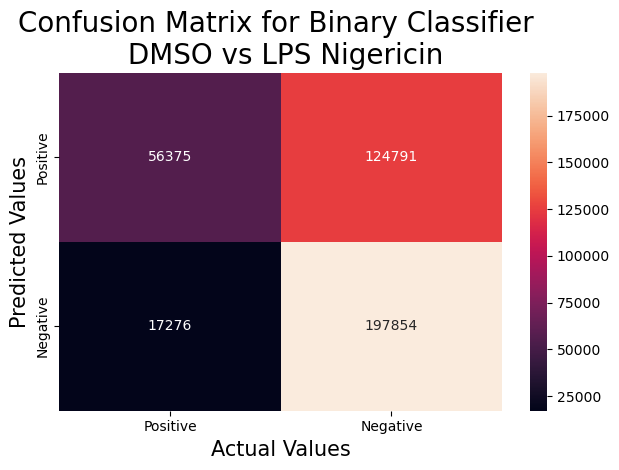

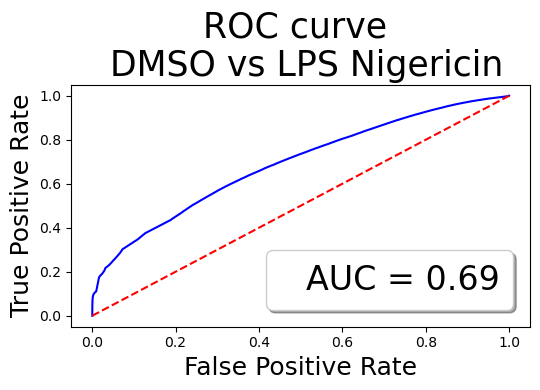

DMSO_0.100_DMSO_0.025 H2O2_100.000_Z-VAD-FMK_100.0


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.85      0.92      0.89    215130
           1       0.89      0.81      0.85    173437

    accuracy                           0.87    388567
   macro avg       0.87      0.86      0.87    388567
weighted avg       0.87      0.87      0.87    388567



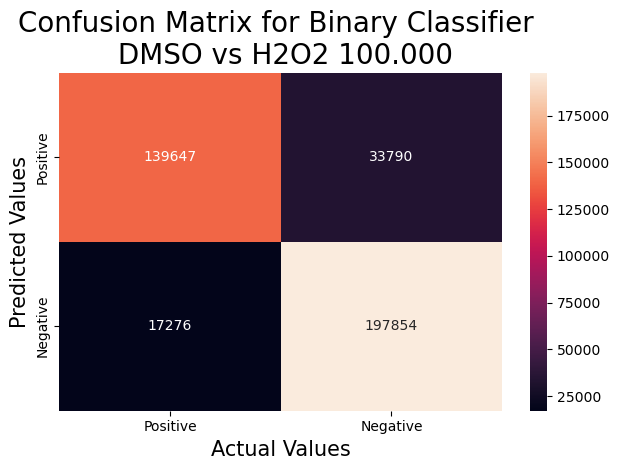

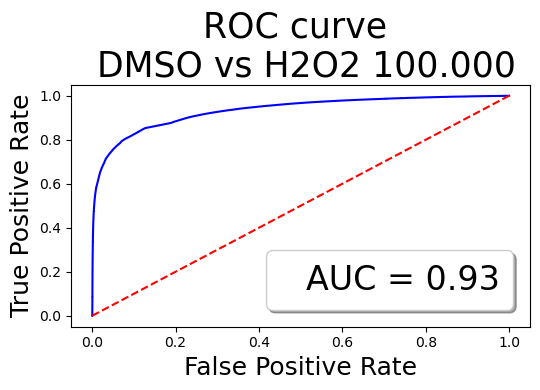

DMSO_0.100_DMSO_0.025 H2O2_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.49      0.92      0.64    215130
           1       0.67      0.15      0.24    240536

    accuracy                           0.51    455666
   macro avg       0.58      0.53      0.44    455666
weighted avg       0.58      0.51      0.43    455666



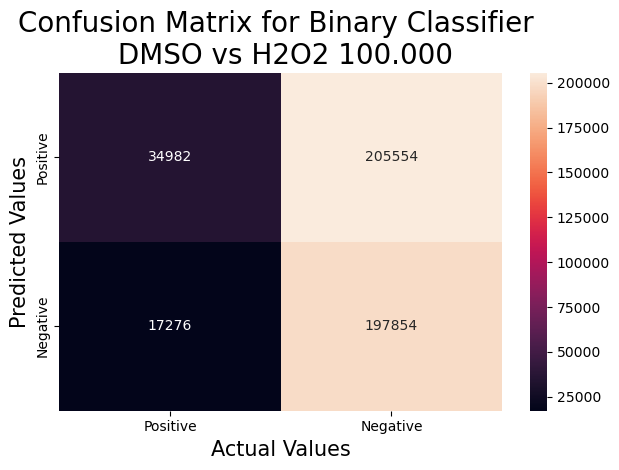

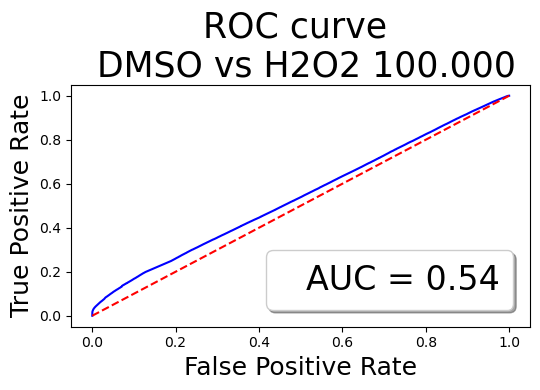

Thapsigargin_1.000_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.70      0.60      0.65    159435
           1       0.63      0.72      0.67    148456

    accuracy                           0.66    307891
   macro avg       0.66      0.66      0.66    307891
weighted avg       0.66      0.66      0.66    307891



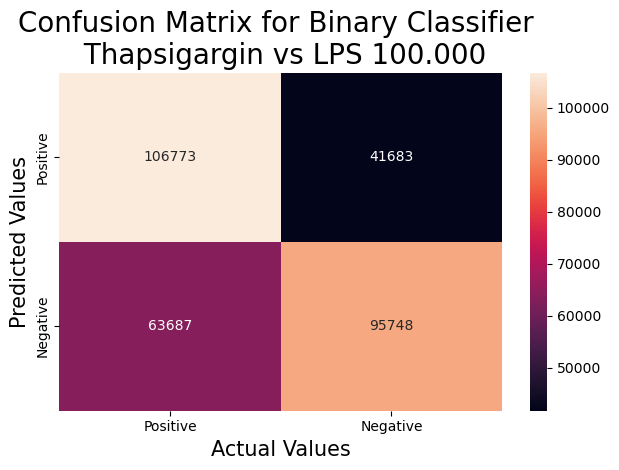

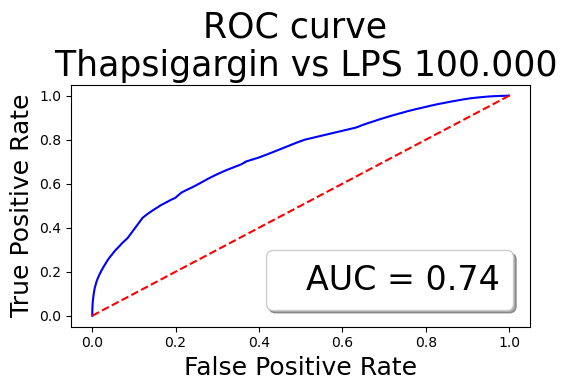

Thapsigargin_10.000_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.71      0.60      0.65    159435
           1       0.67      0.76      0.71    166984

    accuracy                           0.68    326419
   macro avg       0.69      0.68      0.68    326419
weighted avg       0.69      0.68      0.68    326419



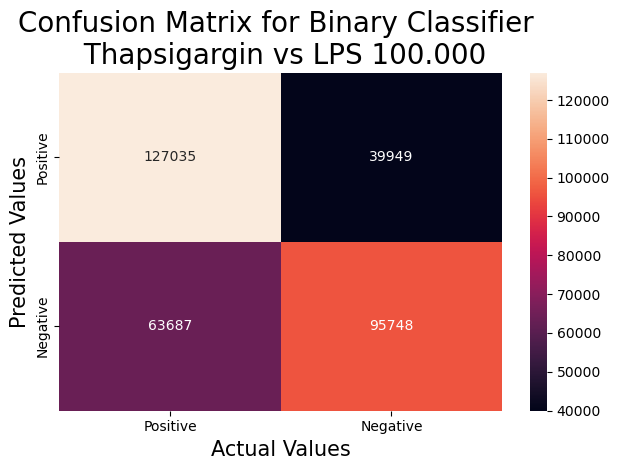

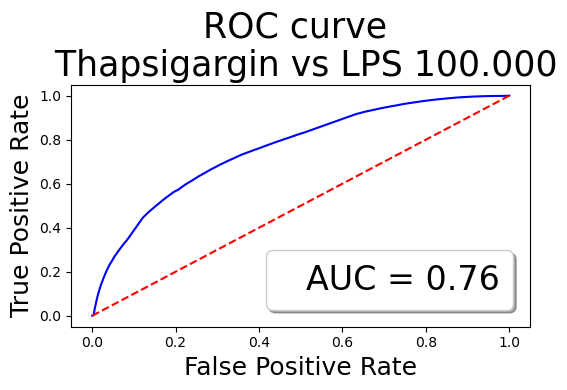

LPS_10.000_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.59      0.38      0.46    156490
           1       0.53      0.72      0.61    148456

    accuracy                           0.55    304946
   macro avg       0.56      0.55      0.54    304946
weighted avg       0.56      0.55      0.53    304946



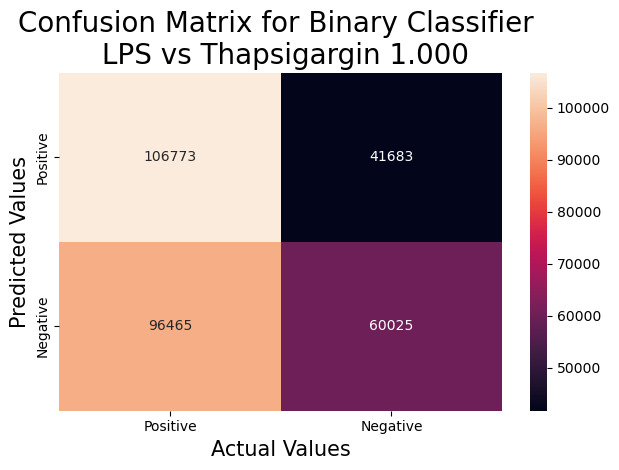

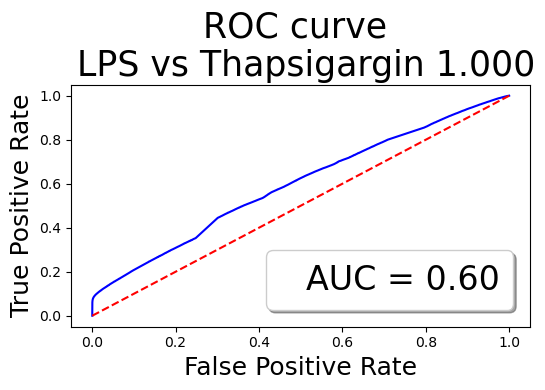

LPS_10.000_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.60      0.38      0.47    156490
           1       0.57      0.76      0.65    166984

    accuracy                           0.58    323474
   macro avg       0.58      0.57      0.56    323474
weighted avg       0.58      0.58      0.56    323474



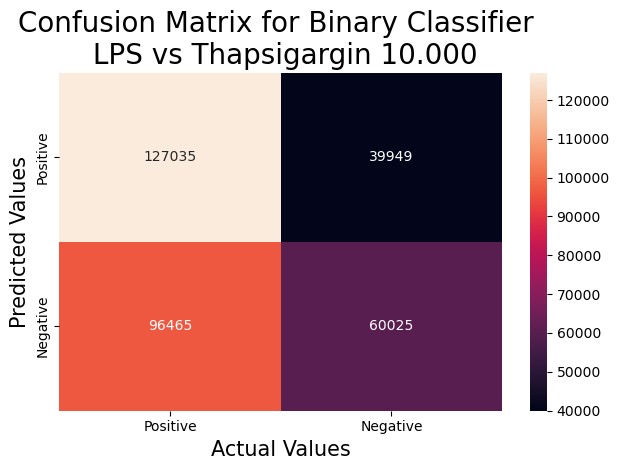

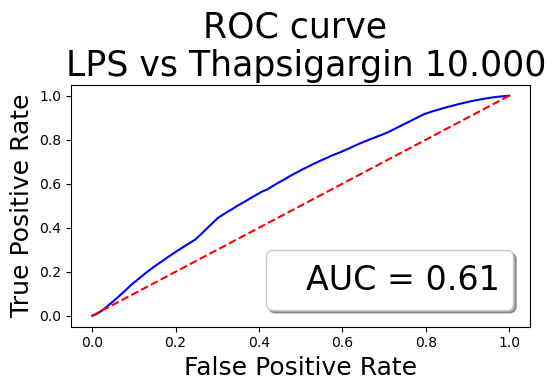

LPS_1.000_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.59      0.42      0.49    139433
           1       0.57      0.72      0.64    148456

    accuracy                           0.58    287889
   macro avg       0.58      0.57      0.56    287889
weighted avg       0.58      0.58      0.57    287889



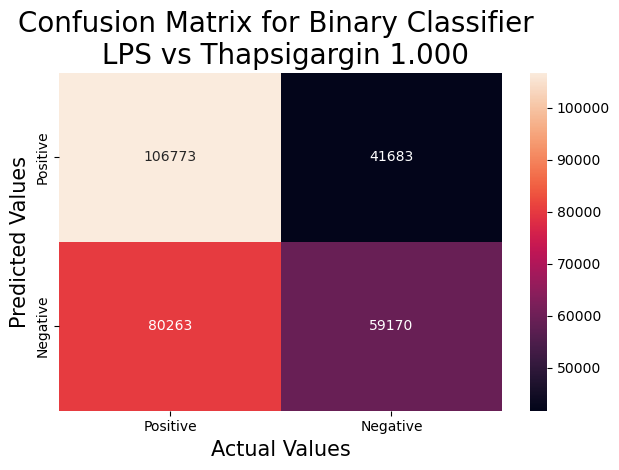

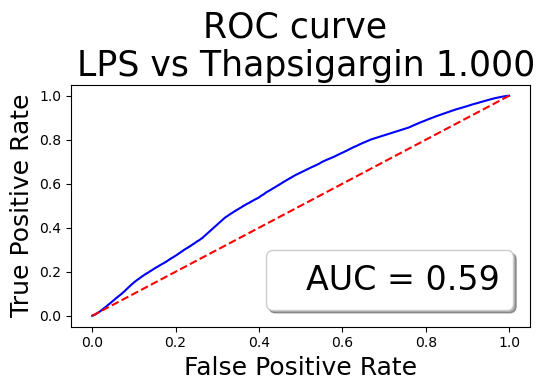

LPS_1.000_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.60      0.42      0.50    139433
           1       0.61      0.76      0.68    166984

    accuracy                           0.61    306417
   macro avg       0.60      0.59      0.59    306417
weighted avg       0.61      0.61      0.60    306417



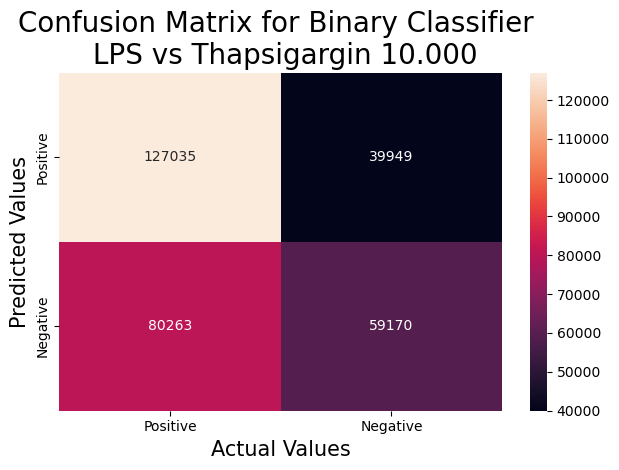

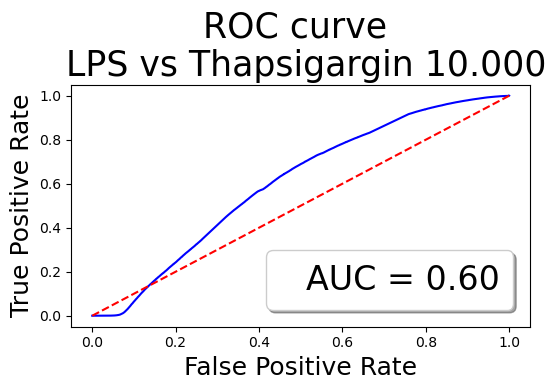

LPS_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.64      0.53      0.58    138597
           1       0.62      0.72      0.67    148456

    accuracy                           0.63    287053
   macro avg       0.63      0.62      0.62    287053
weighted avg       0.63      0.63      0.62    287053



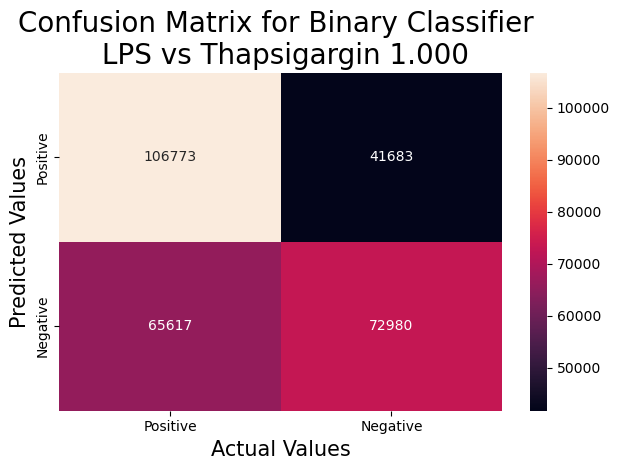

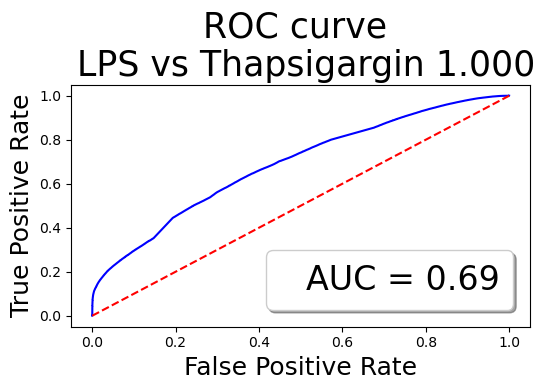

LPS_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.65      0.53      0.58    138597
           1       0.66      0.76      0.71    166984

    accuracy                           0.65    305581
   macro avg       0.65      0.64      0.64    305581
weighted avg       0.65      0.65      0.65    305581



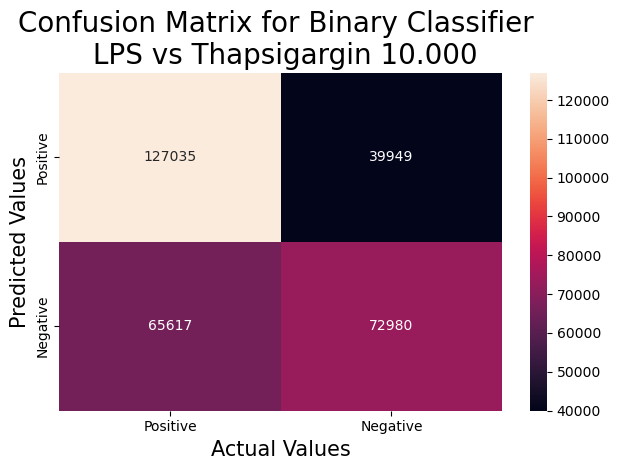

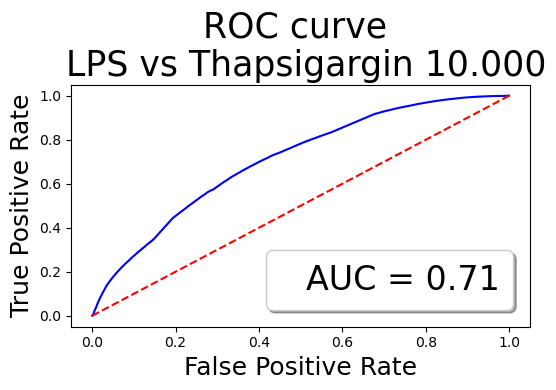

LPS_0.010_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.69      0.64      0.66    143080
           1       0.67      0.72      0.69    148456

    accuracy                           0.68    291536
   macro avg       0.68      0.68      0.68    291536
weighted avg       0.68      0.68      0.68    291536



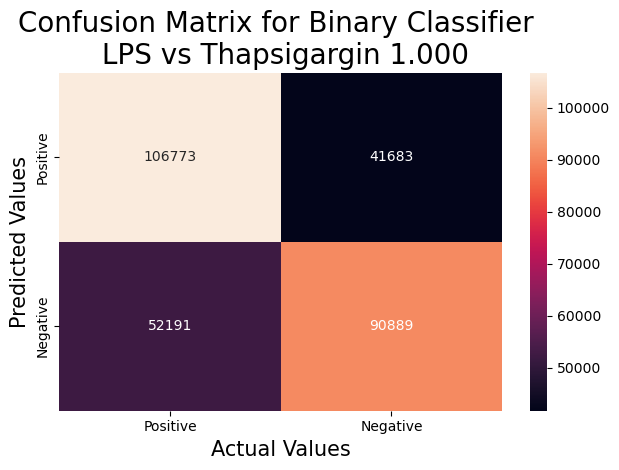

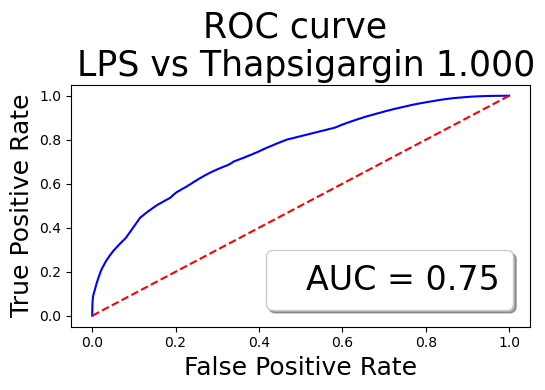

LPS_0.010_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.69      0.64      0.66    143080
           1       0.71      0.76      0.73    166984

    accuracy                           0.70    310064
   macro avg       0.70      0.70      0.70    310064
weighted avg       0.70      0.70      0.70    310064



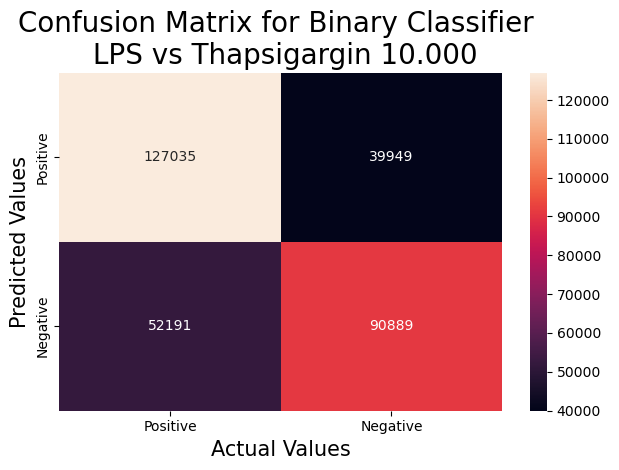

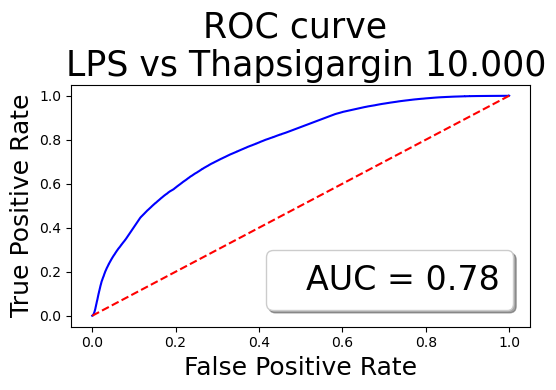

In [8]:
for i, j in paired_treatment_list:
    test_df = df.query(
        f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{j}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}'"
    )
    output_name = (" ").join(
        test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

    print(output_name)

    title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])}'
    test_loop(test_df, output_name, title)